In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
#df_house_data=pd.read_csv("kc_house_data.csv", dtype=dtype_dict)
df_house_train=pd.read_csv("kc_house_train_data.csv", dtype=dtype_dict)
df_house_test=pd.read_csv("kc_house_test_data.csv", dtype=dtype_dict)

In [20]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant']=1
    features=['constant']+features
    
    features_np = data_frame[features].values
    output_np = data_frame[output].values
    
    return features_np, output_np
    

In [10]:
def predict_outcome(feature_matrix, weights):
    predictions=np.dot(feature_matrix,weights)
    #predictions=np.dot(feature_matrix,weights.reshape((weights.size,1)))
    return(predictions)

In [5]:
df_house_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [6]:
df_house_train['bathrooms'].shape

(17384,)

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.


Cost(w)
= SUM[ (prediction - output)^2 ] + l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Module 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w[i] can be written as:


2 * SUM[ error * [feature_i] ]
The derivative of the regularization term with respect to w[i] is:


2 * l2_penalty * w[i]
Summing both, we get


2 * SUM[ error * [feature_i] ] + 2 * l2_penalty * w[i]

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus 2*l2_penalty*w[i].

In [37]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    derivative = 2*np.dot(feature,errors)
    if not feature_is_constant:
        derivative += 2*weight*l2_penalty
    return derivative

In [8]:
(example_features, example_output) = get_numpy_data(df_house_train, ['sqft_living'], 'price')
my_weights = np.array([1., 10.])
#test_predictions = predict_outcome(example_features, my_weights)
#print(test_predictions.shape)
#test_predictions[10:]
#errors = test_predictions - example_output # prediction errors
#print(errors[10:])
#print(np.sum(errors*example_features[:,1])*2+20.)
#example_features[:10,1].shape

In [39]:
(example_features, example_output) = get_numpy_data(df_house_train, ['sqft_living'], 'price')
my_weights = np.array([1., 10.])
test_predictions = predict_outcome(example_features, my_weights)
print(example_features.shape, example_output.shape, test_predictions.shape)
print(type(example_features), type(example_output), type(test_predictions))
errors = test_predictions - example_output # prediction errors
print(errors.shape, example_features[:,1].shape)
# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print(np.sum(errors*example_features[:,1])*2+20.)
print('')

# next two lines should print the same values
print(feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2.)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
(17384, 2) (17384,) (17384,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(17384,) (17384,)
-4.55328923355e+13
-4.55328923355e+13

-18029479492.0
-18029479492.0


Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.

The amount by which we move in the negative gradient direction is called the ‘step size’. We stop when we are ‘sufficiently close’ to the optimum. Unlike in Module 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, write a gradient descent function using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria. The function will take the following parameters:

2D feature matrix
array of output values
initial weights
step size
L2 penalty
maximum number of iterations
To make your job easier, we provide a skeleton in Python:

In [56]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    count = 0
    while count < max_iterations:
        predictions = predict_outcome(feature_matrix, weights)
        errors = predictions - output
        #while not reached maximum number of iterations:
        # compute the predictions using your predict_output() function

        # compute the errors as predictions - output
        for i in range(len(weights)): # loop over each weight
            partial_derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i],l2_penalty,i==0)
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            weights[i]-=step_size*partial_derivative
            # subtract the step size times the derivative from the current weight  
        count+=1
    return weights


In [41]:
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(df_house_train, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(df_house_test, simple_features, my_output)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [45]:
step_size = 1e-12
max_iterations = 1000
initial_weights = np.zeros(2)
l2_penalty = 0

In [59]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
print(simple_weights_0_penalty)

[ -1.63113515e-01   2.63024369e+02]


In [80]:
l2_penalty = 1e10
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations)
print(simple_weights_high_penalty)

[   1.71937112  236.71532287]


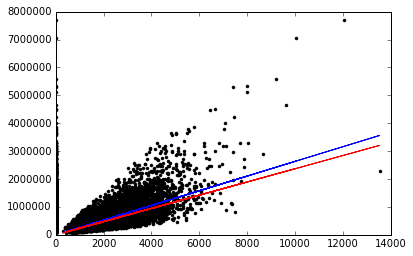

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
        simple_feature_matrix,predict_outcome(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_outcome(simple_feature_matrix, simple_weights_high_penalty),'r-')

In [63]:
(test_feature_matrix, test_output) = get_numpy_data(df_house_test, simple_features, my_output)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [64]:
test_zero_weights_output = predict_outcome(test_feature_matrix, np.zeros(2))

In [65]:
test_non_reg_output = predict_outcome(test_feature_matrix, simple_weights_0_penalty)

In [66]:
test_reg_output = predict_outcome(test_feature_matrix, simple_weights_high_penalty)

In [67]:
RSS_zero_weights = ((test_output - test_zero_weights_output)**2).sum()
RSS_non_reg = ((test_output - test_non_reg_output)**2).sum()
RSS_reg = ((test_output - test_reg_output)**2).sum()
print(RSS_zero_weights, RSS_non_reg, RSS_reg)

1.78427328614e+15 2.75723632154e+14 6.9464210149e+14


In [68]:
test_feature_matrix[0]

array([  1.00000000e+00,   1.43000000e+03])

In [71]:
non_reg_price=np.dot(test_feature_matrix[0],simple_weights_0_penalty)
reg_price=np.dot(test_feature_matrix[0],simple_weights_high_penalty)
print(non_reg_price, reg_price)

376124.684507 178147.978518


In [72]:
print("real price: ", test_output[0])

real price:  310000.0
